## Counting Spectra and Redshifts in EDR

This script was used to generate the numbers of successful redshifts obtained in EDR for the EDR paper, in total and per tracer class.


Author: Anthony Kremin, LBNL

Date: March 2, 2023

### Setup

#### Import modules and set latex table formatting

In [1]:
import sys, os, glob
import numpy as np
import matplotlib.pyplot as plt
import fitsio
from astropy.io import fits
from astropy.table import Table,vstack
from astropy.io import ascii

latex_dict = {'tabletype': 'deluxetable*', 'tablealign':'htb'}
save_figures = False

#### Import desi targeting information from desitarget (https://github.com/desihub/desitarget)

In [2]:
from desitarget.cmx.cmx_targetmask import cmx_mask as cmxmask
from desitarget.sv1.sv1_targetmask import desi_mask as sv1mask
from desitarget.sv2.sv2_targetmask import desi_mask as sv2mask
from desitarget.sv3.sv3_targetmask import desi_mask as sv3mask
from desitarget.targetmask import desi_mask as specialmask
## Example of how to get the other targeting bitmasks
#from desitarget.sv1.sv1_targetmask import desi_mask, bgs_mask, mws_mask, scnd_mask

#### Put masks in dictionary and create list of surveys

In [3]:
desi_masks = {}
desi_masks['cmx'] = cmxmask
desi_masks['sv1'] = sv1mask
desi_masks['sv2'] = sv2mask
desi_masks['sv3'] = sv3mask
desi_masks['special'] = specialmask
surveys = list(desi_masks.keys())

#### Set the path to the redshift catalog

In [4]:
redux_path = '/global/cfs/cdirs/desi/public/edr/spectro/redux/fuji'
catalog_pathname = os.path.join(redux_path,'zcatalog','zall-pix-fuji.fits')

#### Set the path to the VI VAC

In [5]:
vi_path = '/global/cfs/cdirs/desi/public/edr/vac/edr/vi/v1.0'
vi_filenames = {'BGS':'EDR_VI_BGS_v1.csv', 'LRG':'EDR_VI_LRG_v1.csv', 'ELG':'EDR_VI_ELG_v1.csv',
                'QSO_miss':'EDR_VI_missed_QSO_v1.csv', 'QSO':'EDR_VI_QSO_v1.csv'}

#### Define the set of columns we want to keep in the table and set which column in the table holds the target bits for each survey

In [6]:
select_cols = ['TARGETID', 'SURVEY', 'PROGRAM', 'OBJTYPE', 
               'SPECTYPE', 'Z',  'ZWARN',  'DELTACHI2',
               'COADD_FIBERSTATUS',  'TSNR2_LRG', 'ZCAT_NSPEC', 'ZCAT_PRIMARY',
               'CMX_TARGET', 'DESI_TARGET', 'SV1_DESI_TARGET', 'SV2_DESI_TARGET', 'SV3_DESI_TARGET']

mask_colnames = {}
mask_colnames['cmx'] = 'CMX_TARGET'
mask_colnames['sv1'] = 'SV1_DESI_TARGET'
mask_colnames['sv2'] = 'SV2_DESI_TARGET'
mask_colnames['sv3'] = 'SV3_DESI_TARGET'
mask_colnames['special'] = 'DESI_TARGET'
#'ZERR','SV_NSPEC', 'SV_PRIMARY', 'SV1_BGS_TARGET', 'SV1_MWS_TARGET', 'SV1_SCND_TARGET', 

#### Load the catalog into a table, select the desired columns

In [7]:
print(f'Reading {catalog_pathname}')
zcat = Table.read(catalog_pathname)
print(f'Done reading {catalog_pathname}')

## Only keep columns we need to reduce size on disk
zcat = zcat[select_cols]

Reading /global/cfs/cdirs/desi/public/edr/spectro/redux/fuji/zcatalog/zall-pix-fuji.fits
Done reading /global/cfs/cdirs/desi/public/edr/spectro/redux/fuji/zcatalog/zall-pix-fuji.fits


### Basic Object Counting

#### Count the raw numbers of objects before quality cuts

In [8]:
print(f"Raw number of zcat entries: {len(zcat):,}")
for spectype in ['GALAXY', 'QSO', 'STAR']:
    print(f"Raw number of zcat entries for spectype '{spectype}': {np.sum(zcat['SPECTYPE']==spectype):,}")

Raw number of zcat entries: 2,847,435
Raw number of zcat entries for spectype 'GALAXY': 1,718,654
Raw number of zcat entries for spectype 'QSO': 117,771
Raw number of zcat entries for spectype 'STAR': 1,011,010


##### Get the unique object numbers using the ZCAT_PRIMARY column

In [9]:
unique_zcat = zcat[zcat['ZCAT_PRIMARY']]
print(f"Raw number of unique zcat entries: {len(unique_zcat):,}")
for spectype in ['GALAXY', 'QSO', 'STAR']:
    print(f"Raw number of unique zcat entries for spectype '{spectype}': {np.sum(unique_zcat['SPECTYPE']==spectype):,}")

Raw number of unique zcat entries: 2,757,937
Raw number of unique zcat entries for spectype 'GALAXY': 1,663,496
Raw number of unique zcat entries for spectype 'QSO': 112,256
Raw number of unique zcat entries for spectype 'STAR': 982,185


#### Count the numbers of objects without hardware issues

COADD_FIBERSTATUS is a bitmask representing hardware or observing issues. bit 3 (2\^3=8) is informational saying the patrol radius for the fiber is reduced, but if it made it to it's target then it is still a useful spectrum. So we'll allow 2\^3 or no bits being set. 

Bit definitions: https://github.com/desihub/desispec/blob/main/py/desispec/maskbits.py

In [10]:
zcat = zcat[((zcat['COADD_FIBERSTATUS']==0)|(zcat['COADD_FIBERSTATUS']==8))]
zcat.remove_column('COADD_FIBERSTATUS')

print(f"Number of zcat entries with good fiberstatus: {len(zcat):,}")
for spectype in ['GALAXY', 'QSO', 'STAR']:
    print(f"Number of zcat entries with good fiberstatus for spectype '{spectype}': {np.sum(zcat['SPECTYPE']==spectype):,}")

Number of zcat entries with good fiberstatus: 2,262,558
Number of zcat entries with good fiberstatus for spectype 'GALAXY': 1,626,953
Number of zcat entries with good fiberstatus for spectype 'QSO': 115,119
Number of zcat entries with good fiberstatus for spectype 'STAR': 520,486


In [11]:
unique_zcat = zcat[zcat['ZCAT_PRIMARY']]
print(f"Number of unique zcat entries with good fiberstatus: {len(unique_zcat):,}")
for spectype in ['GALAXY', 'QSO', 'STAR']:
    print(f"Raw number of unique zcat entries with good fiberstatus for spectype '{spectype}': {np.sum(unique_zcat['SPECTYPE']==spectype):,}")

Number of unique zcat entries with good fiberstatus: 2,183,282
Raw number of unique zcat entries with good fiberstatus for spectype 'GALAXY': 1,574,168
Raw number of unique zcat entries with good fiberstatus for spectype 'QSO': 109,685
Raw number of unique zcat entries with good fiberstatus for spectype 'STAR': 499,429


#### Count the number of science objects without observing or hardware issues

In [12]:
## Only keep science targets
zcat = zcat[zcat['OBJTYPE']=='TGT']
zcat.remove_column('OBJTYPE')

print(f"Number of targeted objects with good fiberstatus: {len(zcat):,}")
for spectype in ['GALAXY', 'QSO', 'STAR']:
    print(f"Number of targeted objects with good fiberstatus for spectype '{spectype}': {np.sum(zcat['SPECTYPE']==spectype):,}")

Number of targeted objects with good fiberstatus: 1,912,407
Number of targeted objects with good fiberstatus for spectype 'GALAXY': 1,293,461
Number of targeted objects with good fiberstatus for spectype 'QSO': 100,114
Number of targeted objects with good fiberstatus for spectype 'STAR': 518,832


In [13]:
unique_zcat = zcat[zcat['ZCAT_PRIMARY']]
print(f"Number of unique, targeted objects with good fiberstatus: {len(unique_zcat):,}")
for spectype in ['GALAXY', 'QSO', 'STAR']:
    print(f"Number of unique, targeted objects with good fiberstatus for spectype '{spectype}': {np.sum(unique_zcat['SPECTYPE']==spectype):,}")

Number of unique, targeted objects with good fiberstatus: 1,852,883
Number of unique, targeted objects with good fiberstatus for spectype 'GALAXY': 1,259,473
Number of unique, targeted objects with good fiberstatus for spectype 'QSO': 95,500
Number of unique, targeted objects with good fiberstatus for spectype 'STAR': 497,910


#### Count the number of science objects without observing, hardware, or redshift fitting issues

In [14]:
## Remove all spectra with a ZWARN bit set
zcat = zcat[zcat['ZWARN']==0]
zcat.remove_column('ZWARN')

print(f"Number of targeted objects without observing or redshift fitting issues: {len(zcat):,}")
for spectype in ['GALAXY', 'QSO', 'STAR']:
    print(f"Number of targeted objects without observing or redshift fitting issues for spectype '{spectype}': {np.sum(zcat['SPECTYPE']==spectype):,}")

Number of targeted objects without observing or redshift fitting issues: 1,769,157
Number of targeted objects without observing or redshift fitting issues for spectype 'GALAXY': 1,157,535
Number of targeted objects without observing or redshift fitting issues for spectype 'QSO': 94,678
Number of targeted objects without observing or redshift fitting issues for spectype 'STAR': 516,944


In [15]:
unique_zcat = zcat[zcat['ZCAT_PRIMARY']]
print(f"Number of unique, targeted objects without observing or redshift fitting issues: {len(unique_zcat):,}")
for spectype in ['GALAXY', 'QSO', 'STAR']:
    print(f"Number of unique, targeted objects without observing or redshift fitting issues for spectype '{spectype}': {np.sum(unique_zcat['SPECTYPE']==spectype):,}")

Number of unique, targeted objects without observing or redshift fitting issues: 1,712,004
Number of unique, targeted objects without observing or redshift fitting issues for spectype 'GALAXY': 1,125,635
Number of unique, targeted objects without observing or redshift fitting issues for spectype 'QSO': 90,241
Number of unique, targeted objects without observing or redshift fitting issues for spectype 'STAR': 496,128


### Add columns to table to identify rows that pass cuts

#### For each tracer and each survey, use the appropriate bits and bitmasks to identify targeted objects that turned out to be the correct type

In [16]:
# Define the tracers
tracers = ['BGS', 'ELG', 'LRG', 'QSO', 'STAR', 'SCND']

# Initialize columns to keep track of tracers. Set to -1 so we can ensure we fill all rows
for tracer in tracers:
    zcat.add_column(Table.Column(data=-1*np.ones(len(zcat)), dtype=int, name=f"IS{tracer}"))
    

for survey in surveys:
    print(f'Identifying targets for survey: {survey}')
    desi_mask = desi_masks[survey]
    colname = mask_colnames[survey]
    bits = {}
    if survey == 'cmx':
        bgs = desi_mask.mask('MINI_SV_BGS_BRIGHT|SV0_BGS')
        elg = desi_mask.mask('MINI_SV_ELG|SV0_ELG')
        lrg = desi_mask.mask('MINI_SV_LRG|SV0_LRG')
        qso = desi_mask.mask('MINI_SV_QSO|SV0_QSO|SV0_QSO_Z5')
        starbitnames = 'STD_GAIA|SV0_STD_FAINT|SV0_STD_BRIGHT|STD_TEST|STD_CALSPEC|STD_DITHER|' \
                    + 'SV0_MWS_CLUSTER|SV0_MWS_CLUSTER_VERYBRIGHT|SV0_MWS|SV0_WD|BACKUP_BRIGHT|' \
                    + 'BACKUP_FAINT|M31_STD_BRIGHT|M31_H2PN|M31_GC|M31_QSO|M31_VAR|M31_BSPL|M31_M31cen|' \
                    + 'M31_M31out|ORI_STD_BRIGHT|ORI_QSO|ORI_ORI|ORI_HA|M33_STD_BRIGHT|M33_H2PN|M33_GC|' \
                    + 'M33_QSO|M33_M33cen|M33_M33out|SV0_MWS_FAINT|STD_DITHER_GAIA|STD_FAINT|STD_BRIGHT'
        star = desi_mask.mask(starbitnames)
        sec = 2**70 # secondaries don't exist in cmx, so set it to above the 63rd bit
    else:
        bgs = desi_mask.mask('BGS_ANY')
        elg = desi_mask.mask('ELG')
        lrg = desi_mask.mask('LRG')
        qso = desi_mask.mask('QSO') 
        sec = desi_mask.mask('SCND_ANY')
        star = desi_mask.mask('MWS_ANY|STD_FAINT|STD_WD|STD_BRIGHT')
    
    survey_selection = (zcat['SURVEY'] == survey)
    survey_subset = zcat[survey_selection]
    
    ## See if redrock thought it was a galaxy, star, or qso
    GALTYPE = (survey_subset['SPECTYPE'] == 'GALAXY')
    STARTYPE = (survey_subset['SPECTYPE'] == 'STAR')
    QSOTYPE = (survey_subset['SPECTYPE'] == 'QSO')
    
    ## BGS
    PASSES_BIT_SEL = ((survey_subset[colname] & bgs) > 0)
    zcat['ISBGS'][survey_selection] = (PASSES_BIT_SEL & GALTYPE)
    
    ## ELG
    PASSES_BIT_SEL = ((survey_subset[colname] & elg) > 0)
    zcat['ISELG'][survey_selection] = (PASSES_BIT_SEL & GALTYPE)
    
    ## LRG
    PASSES_BIT_SEL = ((survey_subset[colname] & lrg) > 0)
    zcat['ISLRG'][survey_selection] = (PASSES_BIT_SEL & GALTYPE)
    
    ## QSO
    PASSES_BIT_SEL = ((survey_subset[colname] & qso) > 0)
    zcat['ISQSO'][survey_selection] = (PASSES_BIT_SEL & QSOTYPE)
    
    ## STAR
    PASSES_BIT_SEL = ((survey_subset[colname] & star) > 0)
    zcat['ISSTAR'][survey_selection] = (PASSES_BIT_SEL & STARTYPE)
    
    ## Secondaries
    PASSES_BIT_SEL = ((survey_subset[colname] & sec) > 0)
    zcat['ISSCND'][survey_selection] = (PASSES_BIT_SEL)
    
    zcat.remove_column(colname)

Identifying targets for survey: cmx
Identifying targets for survey: sv1
Identifying targets for survey: sv2
Identifying targets for survey: sv3
Identifying targets for survey: special


#### For each of our tracer classes, make sure none of the column entries are still the default (-1), then set column to be a boolean type

In [17]:
for tracer in tracers:
    col = f"IS{tracer}"
    print(f"For {tracer}: {np.sum(zcat[col] < 0):,} not set")
    if np.sum(zcat[col] < 0) == 0:
        zcat[col] = Table.Column(data=zcat[col], name=col, dtype=bool)

For BGS: 0 not set
For ELG: 0 not set
For LRG: 0 not set
For QSO: 0 not set
For STAR: 0 not set
For SCND: 0 not set


#### Show 10 random rows of the resulting catalog

In [18]:
randnumgen = np.random.default_rng(seed=1080)

In [19]:
zcat[randnumgen.integers(0, len(zcat), 10)]

TARGETID,SURVEY,PROGRAM,SPECTYPE,Z,DELTACHI2,TSNR2_LRG,ZCAT_NSPEC,ZCAT_PRIMARY,ISBGS,ISELG,ISLRG,ISQSO,ISSTAR,ISSCND
int64,bytes7,bytes6,bytes6,float64,float64,float32,int64,bool,bool,bool,bool,bool,bool,bool
39627764176781493,sv3,bright,STAR,0.0006512051589547504,1614.00062002506,33.856976,1,True,False,False,False,False,True,False
39627824616702977,sv3,dark,GALAXY,0.9652669682647491,132.1983386427164,112.24431,1,True,False,False,True,False,False,False
39633413543561643,sv3,dark,GALAXY,0.9736539044120412,389.7301772236824,113.56767,1,True,False,True,False,False,False,False
39633451388767942,sv3,dark,GALAXY,1.1564830320477513,112.05410873889923,116.08244,1,True,False,True,False,False,False,False
39627841628802354,sv3,bright,GALAXY,0.31248695426571793,904.6300148963928,14.825026,1,True,True,False,False,False,False,False
39633405595357337,sv3,bright,STAR,-0.00028461184234712016,12193.18407682454,34.808437,1,True,False,False,False,False,True,False
39627646581087921,sv1,dark,GALAXY,1.483089616221255,19.389890372753143,489.17346,1,True,False,True,False,False,False,False
39633132009293716,sv3,bright,STAR,-0.000367803790735847,34307.795368846,22.827435,1,True,False,False,False,False,True,False
39633318446105388,sv2,bright,GALAXY,0.42937467037760424,1234.8255356922746,35.10931,1,True,True,False,True,False,False,False


#### Create a column to indicate whether a row matches any extragalactic target

In [20]:
extragal = np.zeros(len(zcat), dtype=bool)
for tracer in ['BGS', 'ELG', 'LRG', 'QSO']:
    if tracer in tracers:
        col = f"IS{tracer}"
        extragal |= zcat[col].data
zcat.add_column(Table.Column(data=extragal, name='ISEXG'))
nextragal = np.sum(extragal)
print(f"Total number of galaxies identified as extragalactic: {np.sum(extragal):,}")

Total number of galaxies identified as extragalactic: 1,151,076


In [21]:
print(f"Total number of unique galaxies identified as extragalactic: {np.sum((zcat['ZCAT_PRIMARY']&zcat['ISEXG'])):,}")

Total number of unique galaxies identified as extragalactic: 1,116,751


In [22]:
print("Four examples of extragalactic spectra:")
zcat[extragal][randnumgen.integers(0, np.sum(extragal), 4)]

Four examples of extragalactic spectra:


TARGETID,SURVEY,PROGRAM,SPECTYPE,Z,DELTACHI2,TSNR2_LRG,ZCAT_NSPEC,ZCAT_PRIMARY,ISBGS,ISELG,ISLRG,ISQSO,ISSTAR,ISSCND,ISEXG
int64,bytes7,bytes6,bytes6,float64,float64,float32,int64,bool,bool,bool,bool,bool,bool,bool,bool
39633368463180635,sv2,dark,GALAXY,0.7286167333697827,33.708331905305386,73.772316,1,True,False,False,True,False,False,False,True
39633374842716709,sv2,dark,GALAXY,0.6535676681290311,115.52821522951126,94.695625,1,True,False,True,False,False,False,False,True
39633336200595700,sv3,dark,GALAXY,1.319878328327929,76.6831076592207,92.603096,1,True,False,True,False,False,False,False,True
39627799824173093,sv3,dark,GALAXY,0.3696422537920915,1911.7322121411562,113.87543,2,True,True,False,True,False,False,False,True


#### Create a column to indicate whether a row matches any tracer target

In [23]:
anytracer = np.zeros(len(zcat),dtype=bool)
for tracer in tracers:
    col = f"IS{tracer}"
    anytracer |= np.array(zcat[col].data).astype(bool)
zcat.add_column(Table.Column(data=anytracer,name='ISANY'))
print(f"Total number of galaxies categorized: {np.sum(~anytracer):,}")

Total number of galaxies categorized: 68,991


In [24]:
print("Four examples of spectra that didn't fall under any category:")
zcat[~anytracer][randnumgen.integers(0, np.sum(~anytracer), 4)]

Four examples of spectra that didn't fall under any category:


TARGETID,SURVEY,PROGRAM,SPECTYPE,Z,DELTACHI2,TSNR2_LRG,ZCAT_NSPEC,ZCAT_PRIMARY,ISBGS,ISELG,ISLRG,ISQSO,ISSTAR,ISSCND,ISEXG,ISANY
int64,bytes7,bytes6,bytes6,float64,float64,float32,int64,bool,bool,bool,bool,bool,bool,bool,bool,bool
39633042976804511,sv1,dark,GALAXY,0.36101615023563344,2357.181610107422,469.5659,1,True,False,False,False,False,False,False,False,False
39633563661895463,sv1,dark,GALAXY,0.5116680956229888,465.3777820467949,416.69998,1,True,False,False,False,False,False,False,False,False
39628357159092716,sv3,dark,GALAXY,1.6458513965556567,22.285172529518604,923.4673,2,True,False,False,False,False,False,False,False,False
39628527066153692,sv1,dark,GALAXY,0.48979127895555685,291.76439410448074,353.5454,1,True,False,False,False,False,False,False,False,False


### Now counting the VI redshifts

In [25]:
good_vi_cut = 2.5

vicats = []
for tracer, fname in vi_filenames.items():
    pathname = os.path.join(vi_path, fname)
    print(f"Loading: {pathname}")
    vicat = Table.read(pathname)
    print(f"Tracer {tracer} table length: {len(vicat):,}")
    vicat = vicat[vicat['VI_QUALITY']>=good_vi_cut]
    print(f"Tracer {tracer} table length after cut >={good_vi_cut}: {len(vicat):,}")
    vicats.append(vicat)
    print()
    
goodfullvicat = vstack(vicats)
for tracer in np.unique(goodfullvicat['VI_SPECTYPE']):
    print(f"{tracer}: {np.sum(goodfullvicat['VI_SPECTYPE']==tracer):,} objects")

Loading: /global/cfs/cdirs/desi/public/edr/vac/edr/vi/v1.0/EDR_VI_BGS_v1.csv
Tracer BGS table length: 2,718
Tracer BGS table length after cut >=2.5: 2,640

Loading: /global/cfs/cdirs/desi/public/edr/vac/edr/vi/v1.0/EDR_VI_LRG_v1.csv
Tracer LRG table length: 3,561
Tracer LRG table length after cut >=2.5: 3,513

Loading: /global/cfs/cdirs/desi/public/edr/vac/edr/vi/v1.0/EDR_VI_ELG_v1.csv
Tracer ELG table length: 10,315
Tracer ELG table length after cut >=2.5: 7,856

Loading: /global/cfs/cdirs/desi/public/edr/vac/edr/vi/v1.0/EDR_VI_missed_QSO_v1.csv
Tracer QSO_miss table length: 1,717
Tracer QSO_miss table length after cut >=2.5: 1,624

Loading: /global/cfs/cdirs/desi/public/edr/vac/edr/vi/v1.0/EDR_VI_QSO_v1.csv
Tracer QSO table length: 3,779
Tracer QSO table length after cut >=2.5: 3,266

GALAXY: 14,939 objects
QSO: 3,182 objects
STAR: 778 objects


In [26]:
2718+10315+3561, 2640+7856+3513, 1717+3779, 1624+3266

(16594, 14009, 5496, 4890)

In [27]:
goodfullvicat.colnames

['TARGETID',
 'TILEID',
 'FIBER',
 'TARGET_RA',
 'TARGET_DEC',
 'VI_Z',
 'VI_QUALITY',
 'VI_SPECTYPE']

### Generate Tables and Plots

#### For each survey, count the number of unique targets of each tracer and output to a table

In [28]:
def latex_N_subscript(subscript):
    return r'N${}_{\mathrm{'+subscript+r'}}$'

def format_number(number):
    return f"{number:,}"

def populate_row(survey, subset_table, tracers):
    row = {'SURVEY':survey}
    for tracer in tracers:
        if tracer == 'TOTAL':
            colname = 'ISANY'
        else:
            colname = f"IS{tracer}"
        num = int(np.sum(subset_table[colname]))
        row[latex_N_subscript(tracer)] = format_number(num)
    return row

subsets = {}
colnames = ['SURVEY']
colnames.extend([latex_N_subscript(subscript) for subscript in tracers])
goodredshifttab = Table(names=colnames, dtype=['S10']*len(colnames))

for survey in surveys:
    subset = zcat[zcat['SURVEY']==survey]

    #- Don't double count repeats                                                                                            
    #- Select the "best" observation by the DELTACHI2                                                                                              
    subset.sort(['TSNR2_LRG'])
    subset=subset[::-1]
    targetids, ii = np.unique(subset['TARGETID'], return_index=True)
    if len(targetids) < len(subset):
        print(f"There were duplicates in survey {survey}, reducing from {len(subset):,} to {len(targetids):,}")
        subset = subset[ii]

    subsets[survey] = subset
    goodredshifttab.add_row(populate_row(survey, subset, tracers))

survey = 'Total'
subset = zcat[zcat['ZCAT_PRIMARY']]
subsets[survey] = subset
row = populate_row(survey, subset, tracers)
goodredshifttab.add_row(row)

print("\nLatex table of number counts:\n")
ascii.write(goodredshifttab, format='aastex', latexdict=latex_dict)


There were duplicates in survey sv1, reducing from 547,305 to 542,573
There were duplicates in survey sv2, reducing from 105,820 to 101,980
There were duplicates in survey sv3, reducing from 1,099,298 to 1,071,229

Latex table of number counts:

\begin{deluxetable*}{ccccccc}[htb]
\tablehead{\colhead{SURVEY} & \colhead{N${}_{\mathrm{BGS}}$} & \colhead{N${}_{\mathrm{ELG}}$} & \colhead{N${}_{\mathrm{LRG}}$} & \colhead{N${}_{\mathrm{QSO}}$} & \colhead{N${}_{\mathrm{STAR}}$} & \colhead{N${}_{\mathrm{SCND}}$}}
\startdata
cmx & 247 & 761 & 1,037 & 275 & 468 & 0 \\
sv1 & 134,419 & 111,692 & 66,161 & 29,839 & 163,254 & 60,430 \\
sv2 & 46,628 & 12,308 & 22,151 & 11,032 & 10,506 & 0 \\
sv3 & 253,915 & 312,790 & 137,317 & 34,173 & 295,232 & 75,947 \\
special & 925 & 3,866 & 3,588 & 3,045 & 867 & 3,482 \\
Total & 428,758 & 437,664 & 227,318 & 76,079 & 466,447 & 137,148
\enddata
\end{deluxetable*}


In [29]:
for survey, subset in subsets.items():
    print(f"\nFor {survey}:")
    
    for spectype in ['STAR', 'GALAXY', 'QSO']:
        spectype_selection = (subset['SPECTYPE']==spectype)
        print(f"\t{spectype}: {np.sum(subset['SPECTYPE']==spectype):,}")


For cmx:
	STAR: 616
	GALAXY: 2,223
	QSO: 346

For sv1:
	STAR: 181,404
	GALAXY: 327,944
	QSO: 33,225

For sv2:
	STAR: 10,915
	GALAXY: 79,236
	QSO: 11,829

For sv3:
	STAR: 306,052
	GALAXY: 721,026
	QSO: 44,151

For special:
	STAR: 1,236
	GALAXY: 9,078
	QSO: 3,235

For Total:
	STAR: 496,128
	GALAXY: 1,125,635
	QSO: 90,241


#### Setup a simple function to nicely print number of spectra in a sample, also define colors for plotting each sample

In [30]:
def get_N_summary_str(number):
    number = int(number)
    if number < 1e3:
        return str(number)
    if number < 1e6:
        return f'{number//int(1e3):d}k'
    else:
        return f'{number//int(1e6)}M'


colors = {'STAR':'C5', 'BGS':'C4', 'LRG':'C3', 'ELG':'C2', 'QSO':'C0'}
stellar_lims = [-0.0015, 0.0015]
extragal_lims = [0, 4.0]
nbins = 40

#### For each survey, plot the N(z) distribution for the DESI main tracer classes

For cmx:



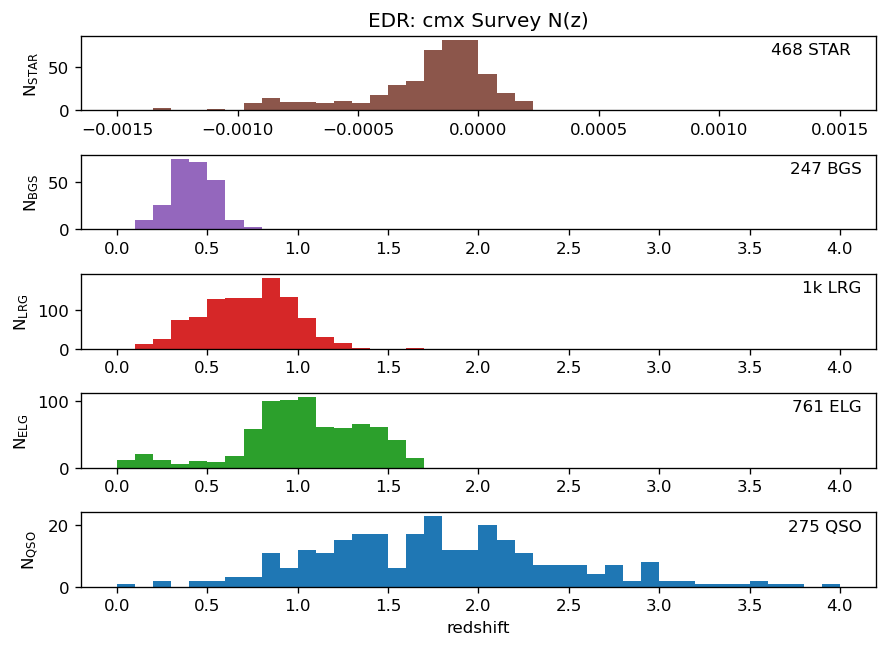




For sv1:



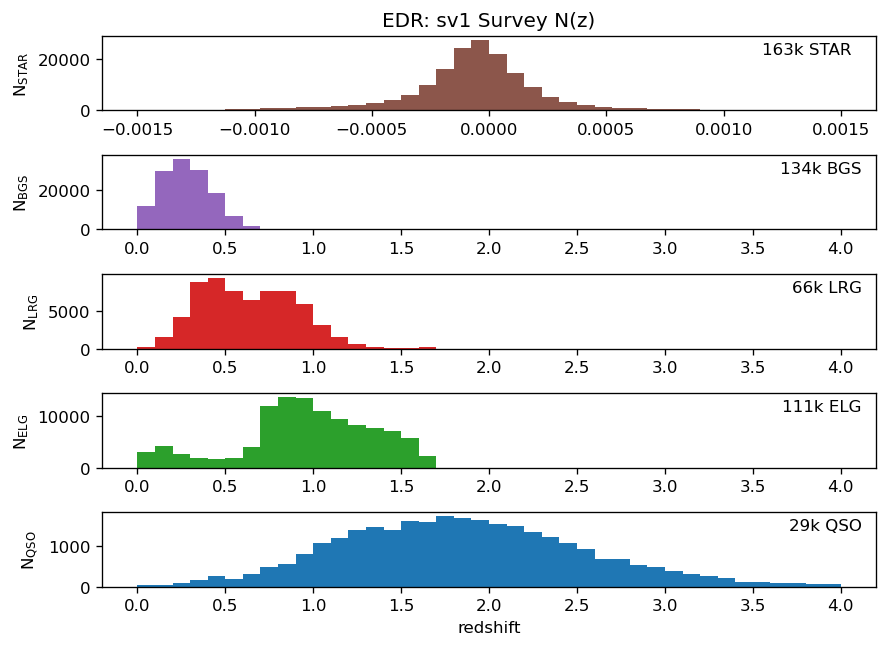




For sv2:



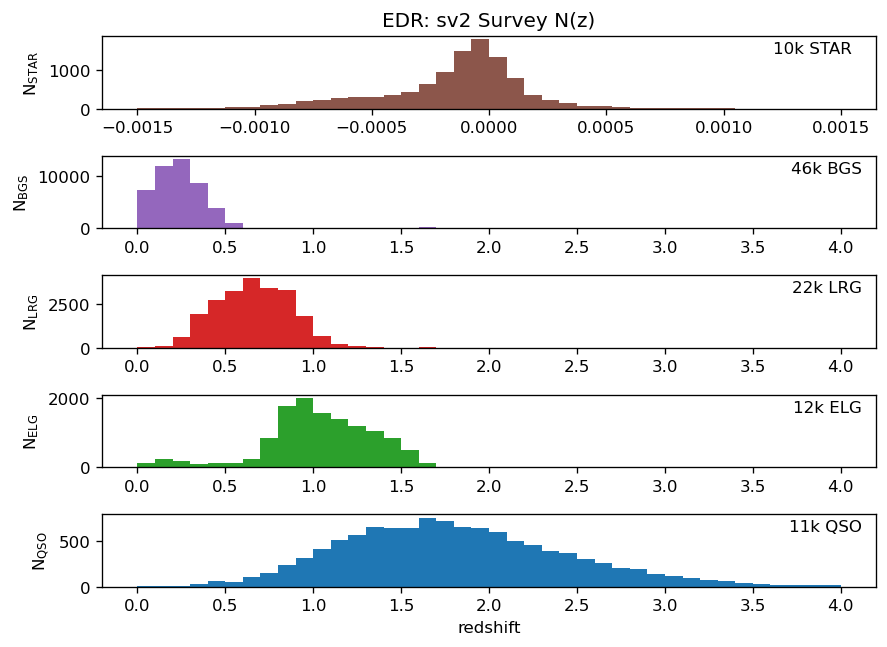




For sv3:



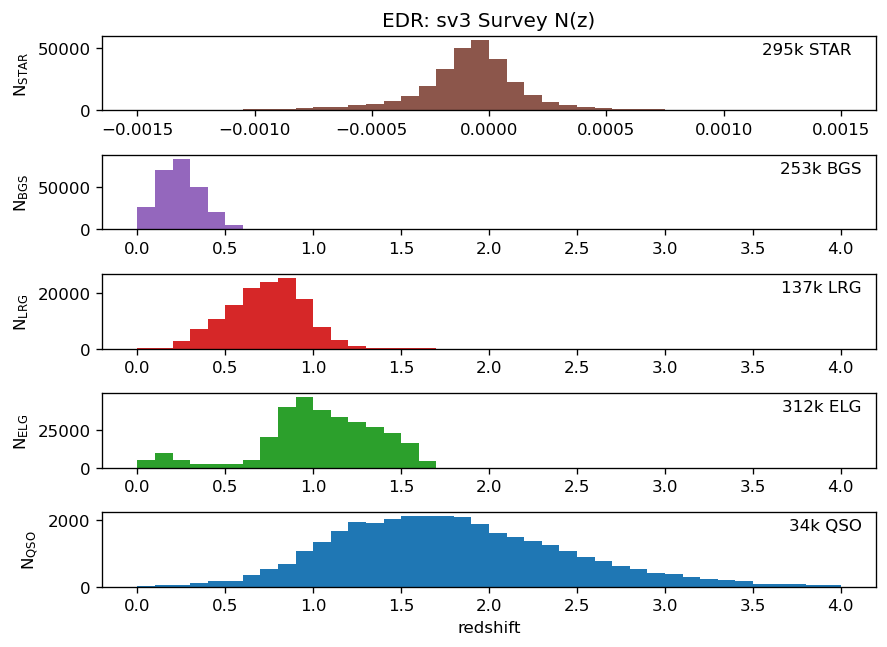




For special:



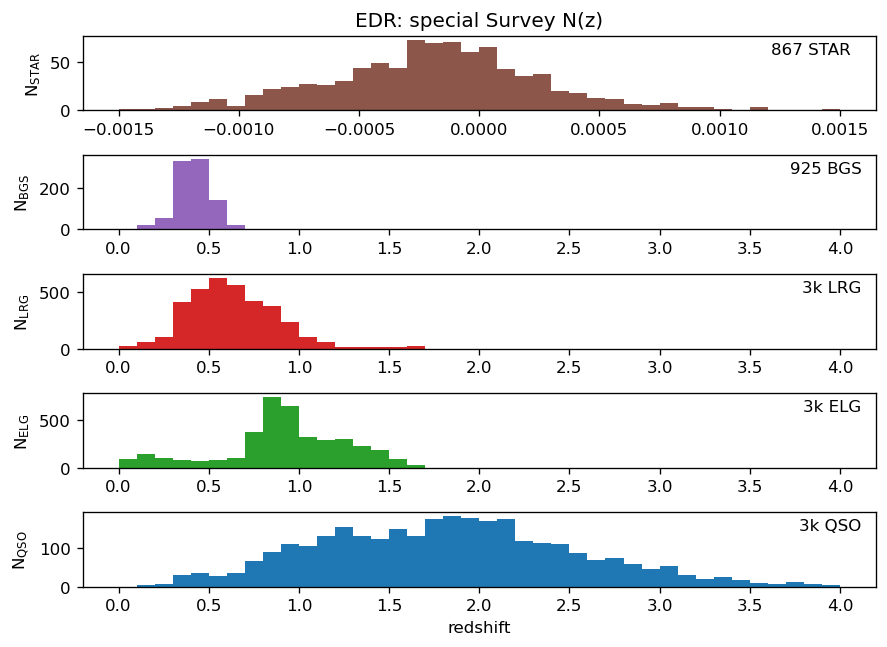




For Total:



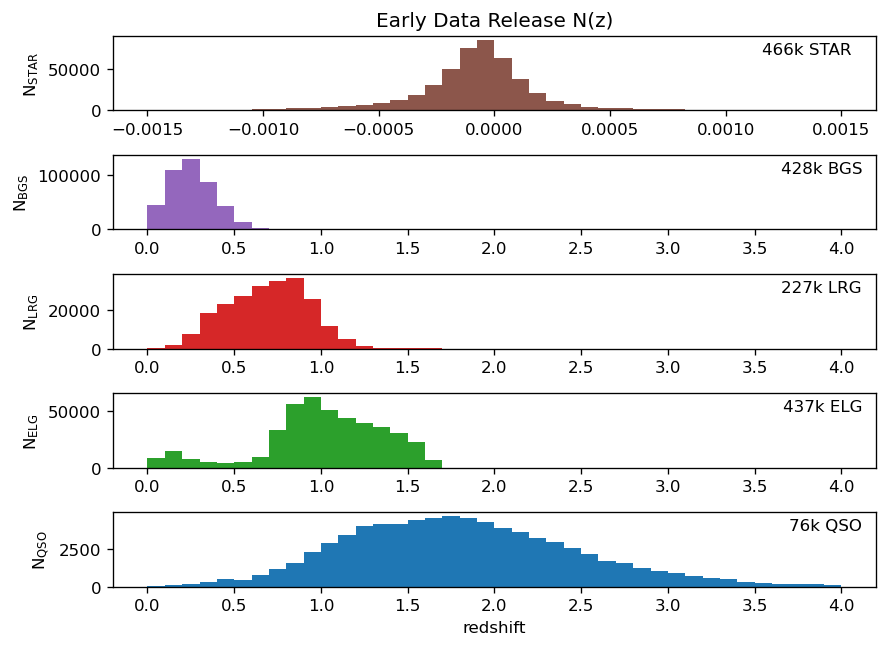

In [31]:
for survey, subset in subsets.items():
    plt.figure(figsize=(7.5,5.5), dpi=120)
    plt.subplot(511)

    if survey == 'Total':
        title_survey = 'Early Data Release'
    else:
        title_survey = f'EDR: {survey} Survey'

    plt.title(f'{title_survey} N(z)')

    print(f"For {survey}:\n")
    
    for i, tracer in enumerate(['STAR', 'BGS', 'LRG', 'ELG', 'QSO']):
        plt.subplot(511+i)
        colname = f"IS{tracer}"
            
        if tracer == 'STAR':
            lims =  stellar_lims
        else:
            lims = extragal_lims

        n = plt.hist(subset['Z'][subset[colname]], bins=nbins, range=lims, color=colors[tracer])[0]
        plt.ylabel(latex_N_subscript(tracer))
        
        plt.text(lims[1]*1.03, int(0.8*np.max(n)), f'{get_N_summary_str(np.sum(subset[colname]))} {tracer}', ha='right')

    plt.xlabel('redshift')

    plt.tight_layout()
    if save_figures:
        plt.savefig(f'./generated_figures/edr_{survey.lower()}_Nz.png', facecolor='white', dpi=200)
    plt.show()
    print("\n\n")

    plt.close()


#### For each survey, plot the stacked N(z) distribution for the DESI main extragalactic tracer classes

For cmx:



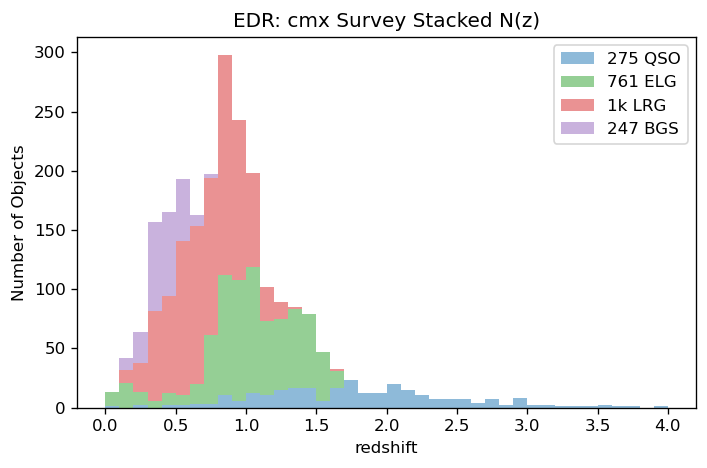




For sv1:



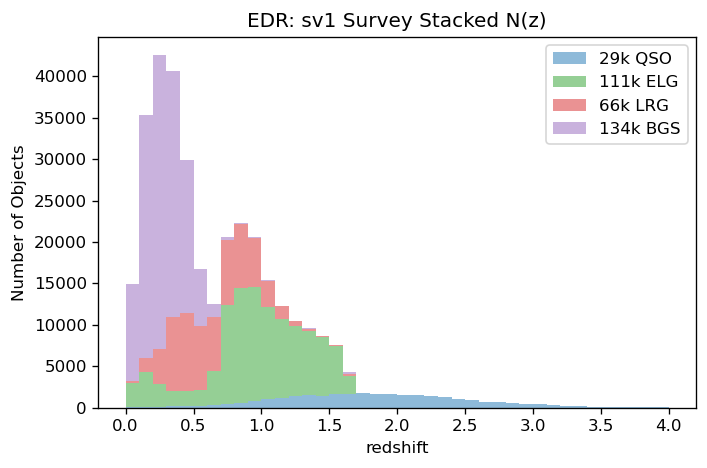




For sv2:



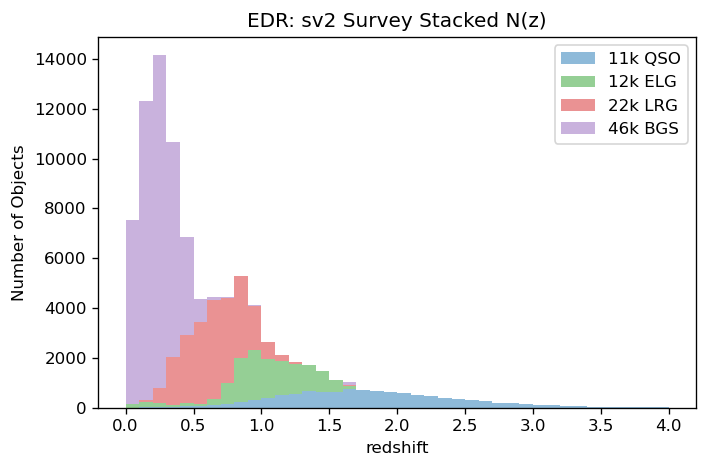




For sv3:



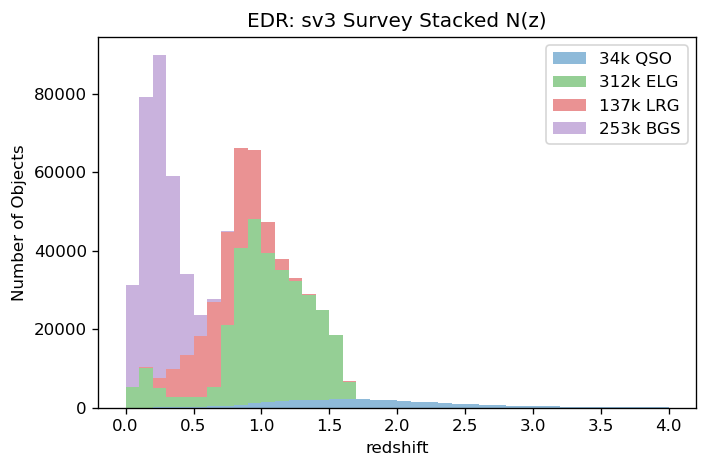




For special:



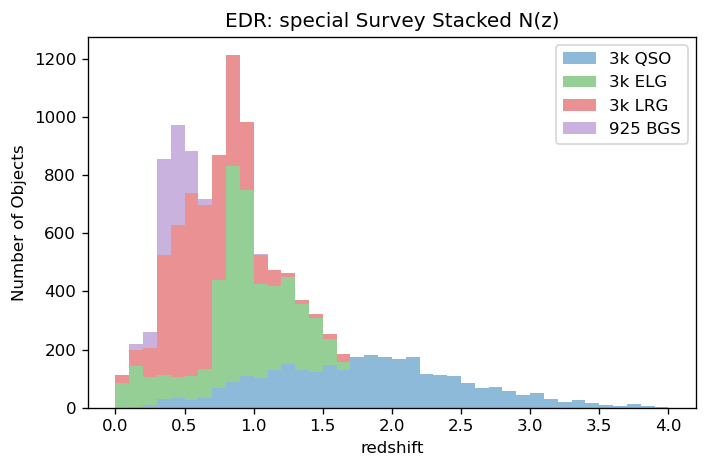




For Total:



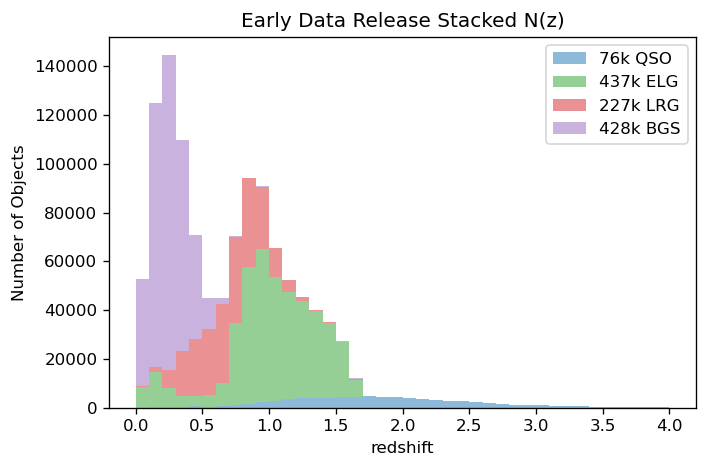

In [32]:
for survey, subset in subsets.items():
    plt.figure(figsize=(6,4), dpi=120)

    if survey == 'Total':
        title_survey = 'Early Data Release'
    else:
        title_survey = f'EDR: {survey} Survey'

    plt.title(f'{title_survey} Stacked N(z)')

    print(f"For {survey}:\n")
    zs, labels, colorlist = list(), list(), list()
    for i, tracer in enumerate(['BGS', 'LRG', 'ELG', 'QSO'][::-1]):
        colname = f"IS{tracer}"
        zs.append(subset['Z'][subset[colname]])
        labels.append(f'{get_N_summary_str(np.sum(subset[colname]))} {tracer}')
        colorlist.append(colors[tracer])
        
    lims = extragal_lims
    n = plt.hist(zs, bins=nbins, range=lims, 
                 color=colorlist, alpha=0.5, label=labels, stacked=True, histtype='barstacked')[0]
    plt.ylabel('Number of Objects')
        
    plt.legend()
    plt.xlabel('redshift')

    plt.tight_layout()
    if save_figures:
        plt.savefig(f'./generated_figures/edr_stacked_{survey.lower()}_Nz.png', facecolor='white', dpi=200)
    plt.show()
    print("\n\n")
    plt.close()

#### For each survey, plot the *stacked* N(z) distribution for the Redrock SPECTYPE classes

For cmx:



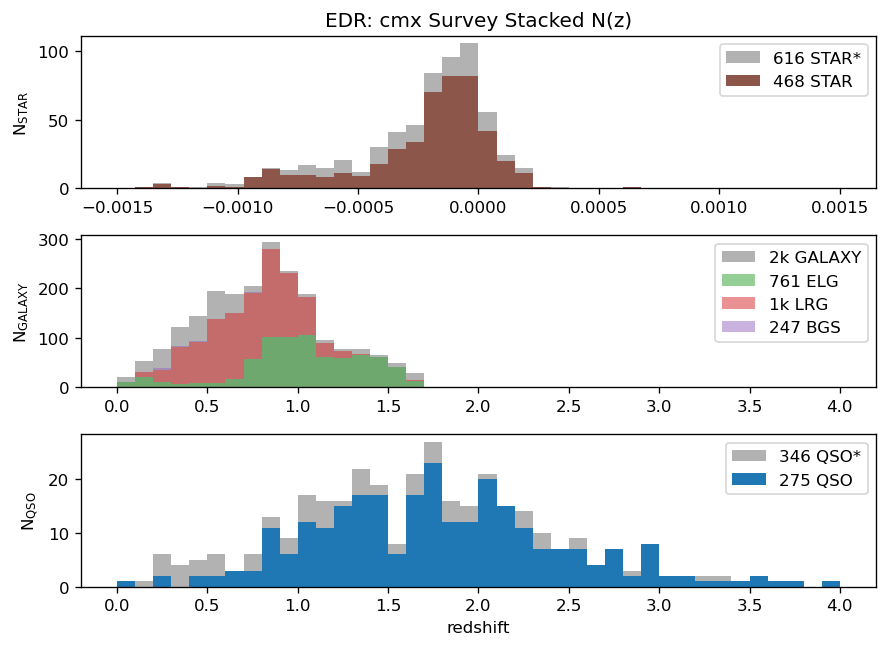




For sv1:



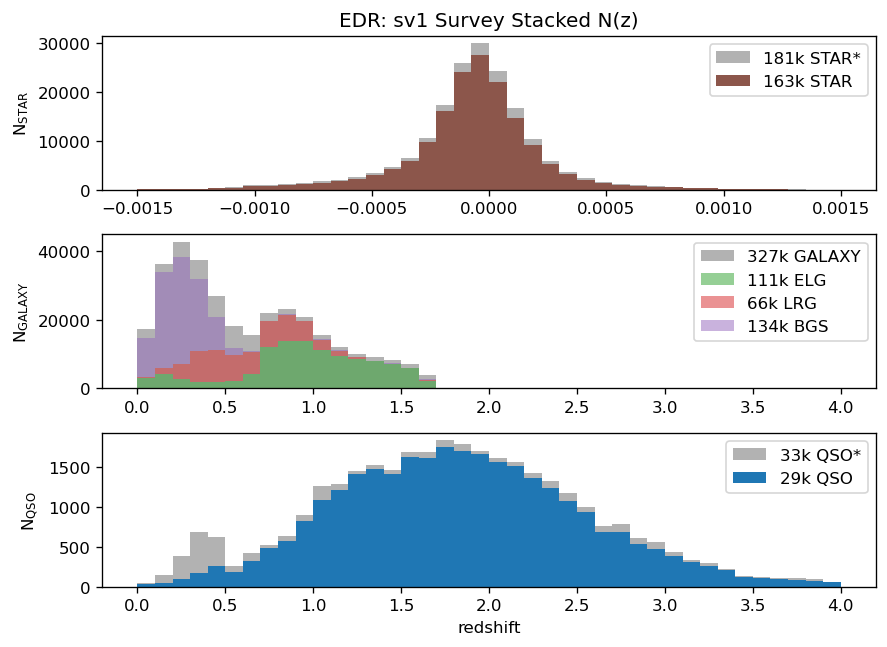




For sv2:



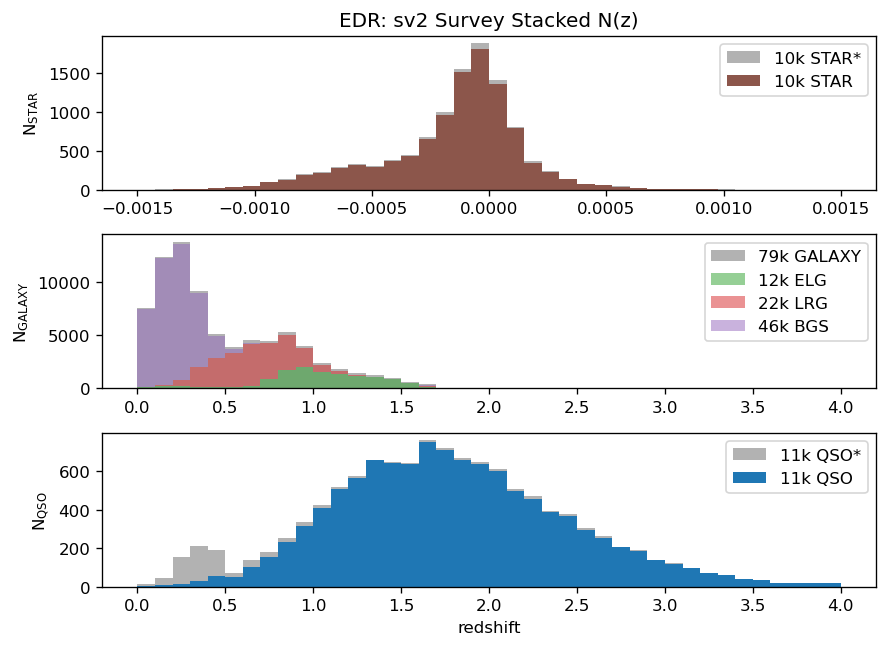




For sv3:



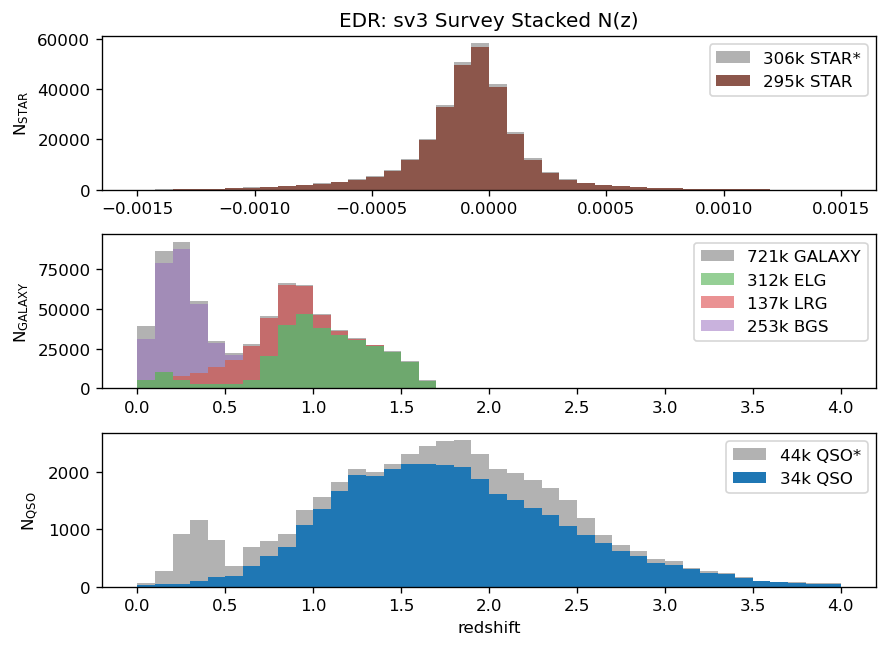




For special:



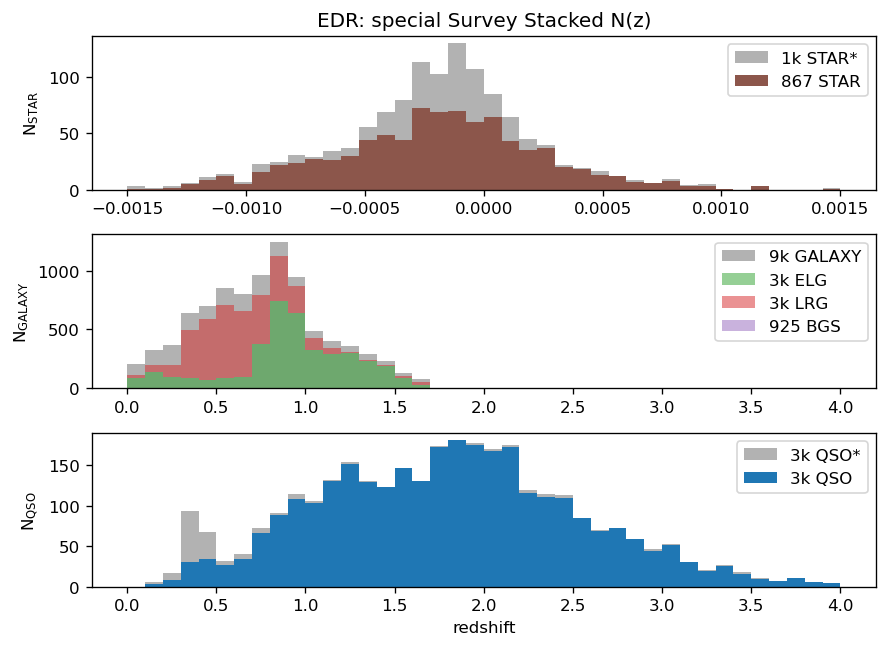




For Total:



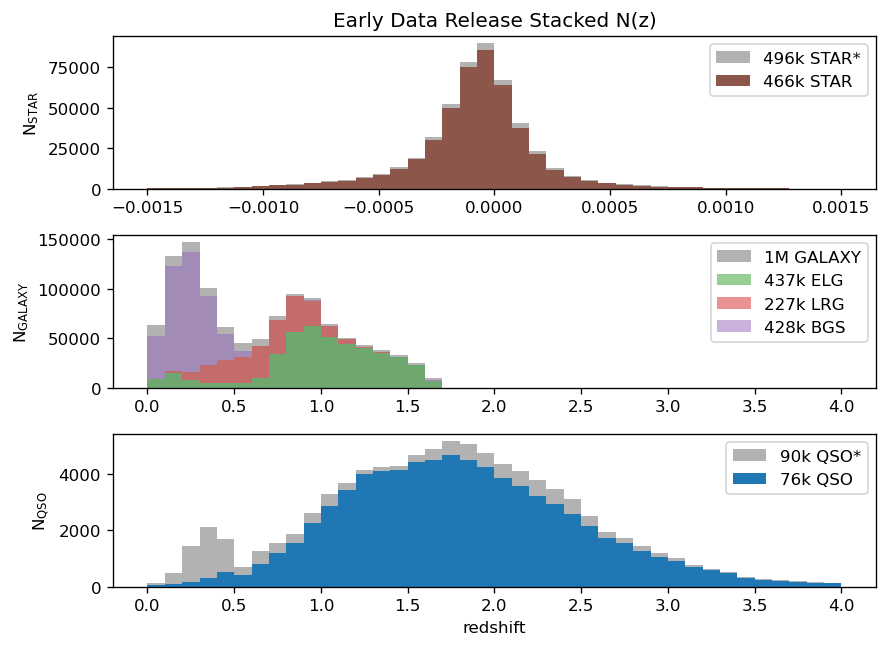

In [33]:
for survey, subset in subsets.items():
    plt.figure(figsize=(7.5,5.5), dpi=120)
    plt.subplot(311)

    if survey == 'Total':
        title_survey = 'Early Data Release'
    else:
        title_survey = f'EDR: {survey} Survey'

    plt.title(f'{title_survey} Stacked N(z)')

    print(f"For {survey}:\n")
    
    for i, spectype in enumerate(['STAR', 'GALAXY', 'QSO']):
        plt.subplot(311+i)
            
        if spectype == 'STAR':
            lims =  stellar_lims
        else:
            lims = extragal_lims

        if spectype == 'GALAXY':
            zs, labels, colorlist = list(), list(), list()
            for i, tracer in enumerate(['BGS', 'LRG', 'ELG'][::-1]):
                colname = f"IS{tracer}"
                if tracer == 'BGS':
                    zs.append(subset['Z'][((subset[colname])&(~subset['ISLRG']))])
                elif tracer == 'LRG':
                    zs.append(subset['Z'][((subset[colname])&(~subset['ISELG']))])    
                else:
                    zs.append(subset['Z'][subset[colname]])
                labels.append(f'{get_N_summary_str(np.sum(subset[colname]))} {tracer}')
                colorlist.append(colors[tracer])
            spectype_selection = (subset['SPECTYPE']==spectype)
            n = plt.hist(subset['Z'][spectype_selection], bins=nbins, range=lims, 
                         color='gray', alpha=0.6, label=f'{get_N_summary_str(np.sum(spectype_selection))} {spectype}')[0]
            n = plt.hist(zs, bins=nbins, range=lims, color=colorlist, alpha=0.5, 
                         label=labels, stacked=True, histtype='barstacked')[0]
        else:
            tracer = spectype
            colname = f"IS{tracer}"     
            spectype_selection = (subset['SPECTYPE']==spectype)
            n = plt.hist(subset['Z'][spectype_selection], bins=nbins, range=lims, color='gray', 
                         alpha=0.6, label=f'{get_N_summary_str(np.sum(spectype_selection))} {spectype}*')[0]
            n = plt.hist(subset['Z'][subset[colname]], bins=nbins, range=lims, color=colors[tracer],
                         label=f'{get_N_summary_str(np.sum(subset[colname]))} {tracer}')[0]

        plt.ylabel(latex_N_subscript(spectype))
        plt.legend()

    plt.xlabel('redshift')

    plt.tight_layout()
    if save_figures:
        plt.savefig(f'./generated_figures/edr_stacked_{survey.lower()}_Nz_withallspectype.png', facecolor='white', dpi=200)
    plt.show()
    print("\n\n")

    plt.close()


#### For each survey, plot the N(z) distribution for the Redrock SPECTYPE classes

For cmx:



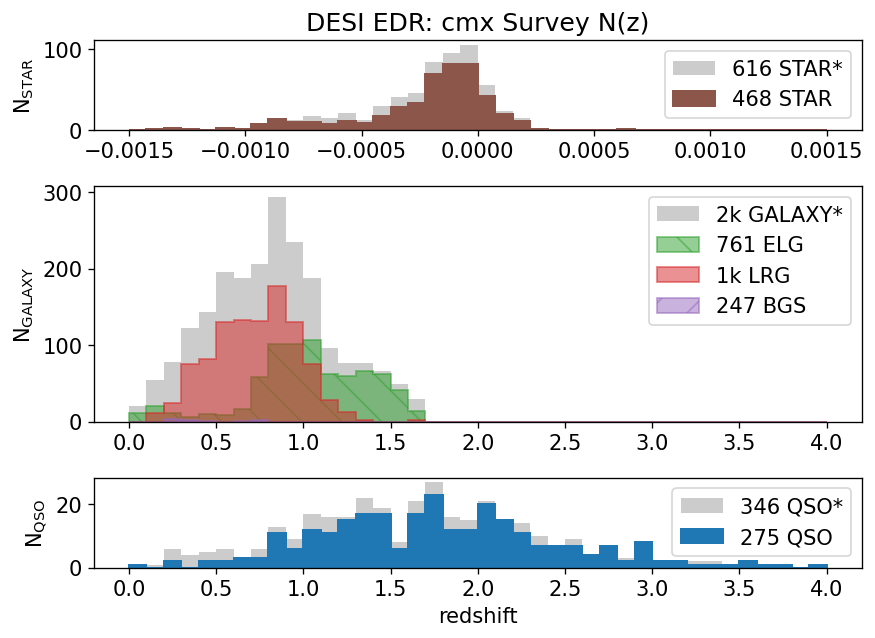




For sv1:



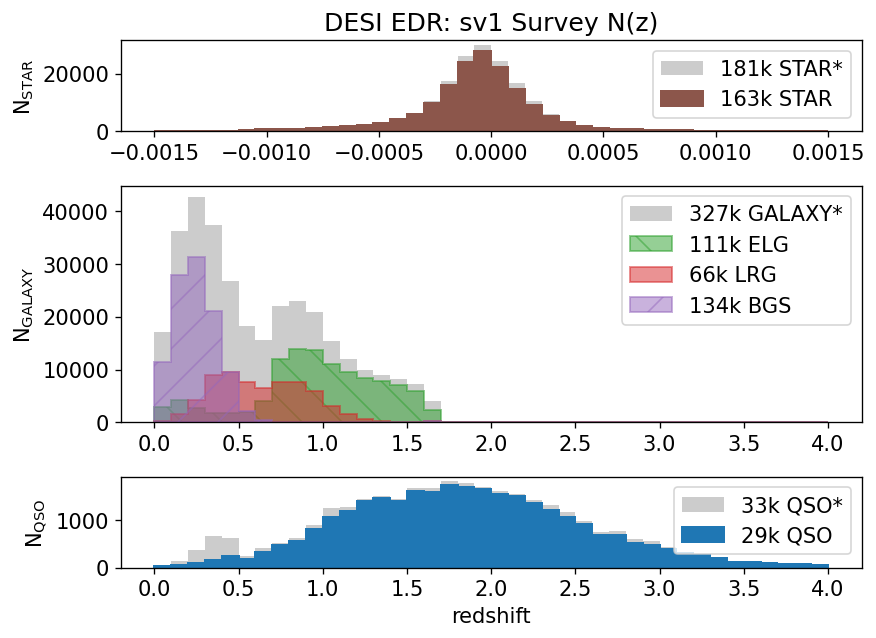




For sv2:



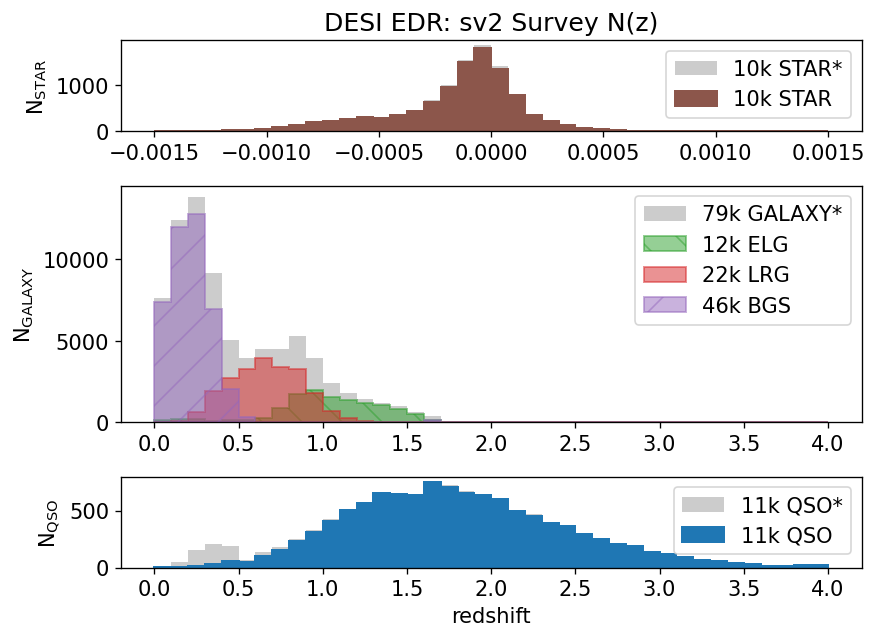




For sv3:



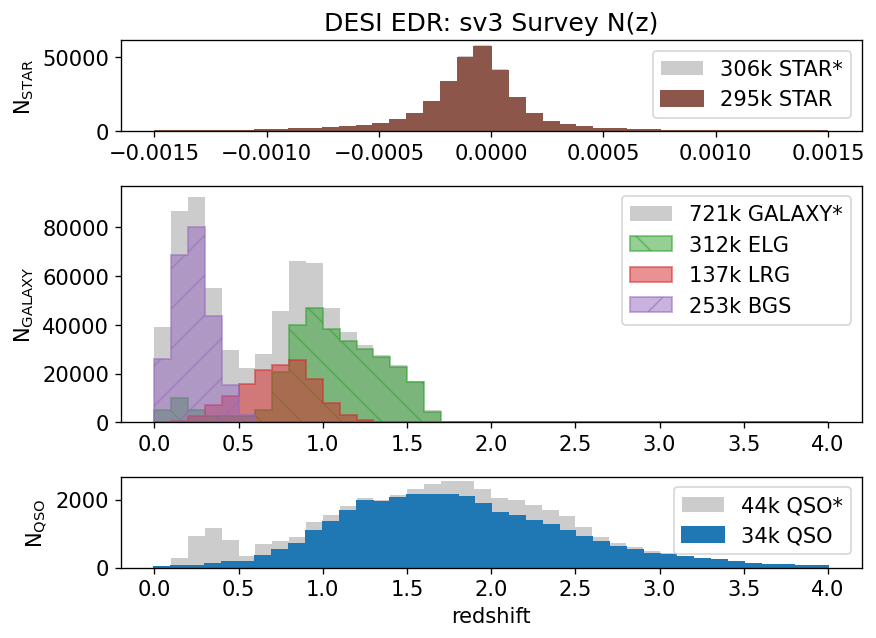




For special:



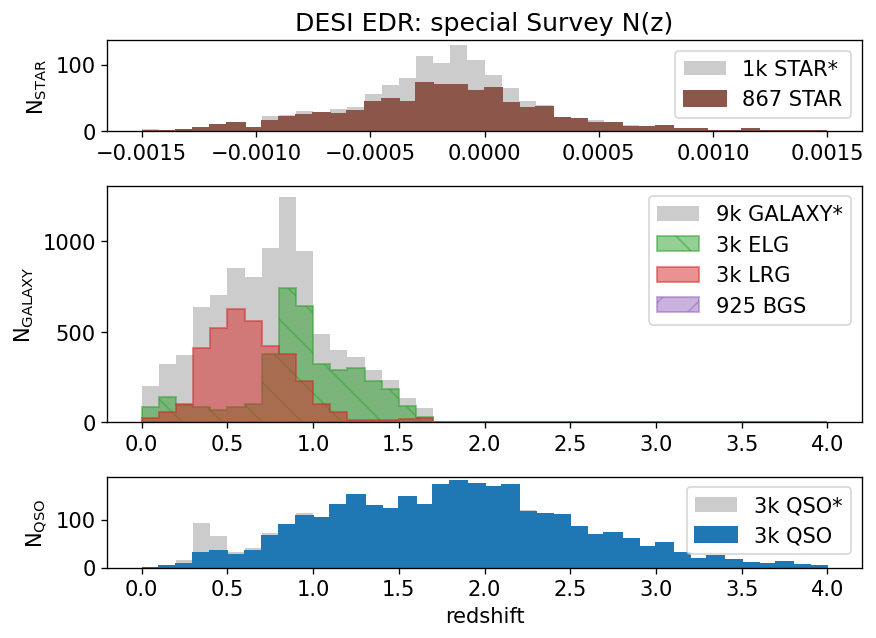




For Total:



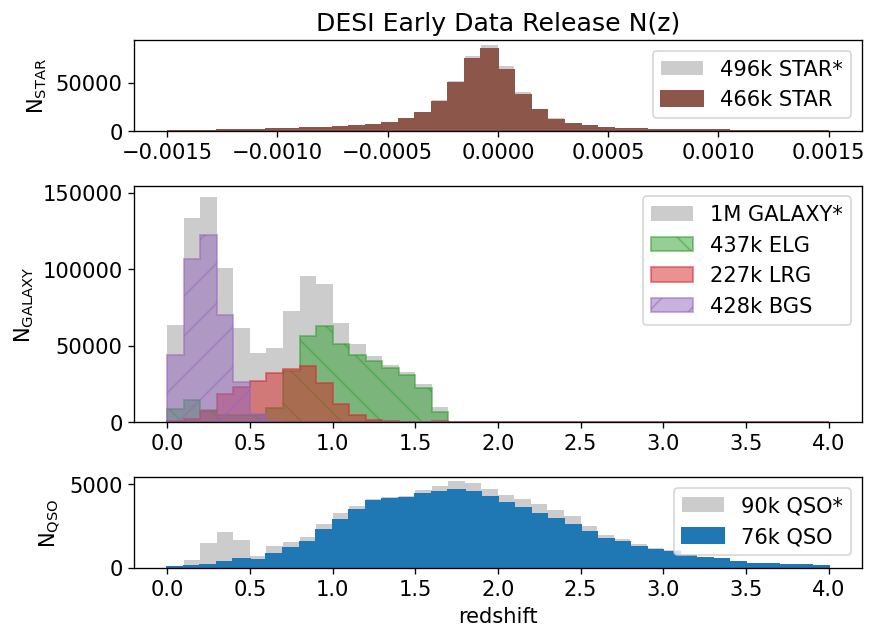

In [34]:
#linestyles = {'BGS': 'solid', 'LRG': 'dashed', 'ELG': 'dotted'}
hatches = {'BGS': '/', 'LRG': r'', 'ELG': "\\"}
import matplotlib
matplotlib.rcParams.update({'font.size': 12.6})

for survey, subset in subsets.items():
    # plt.figure(figsize=(7.5,5.5), dpi=120)
    plt.figure(figsize=(7.5,5.5), dpi=120)

    plot1 = plt.subplot2grid((8, 1), (0, 0), rowspan=2)
    plot2 = plt.subplot2grid((8, 1), (2, 0), rowspan=4)
    plot3 = plt.subplot2grid((8, 1), (6, 0), rowspan=2)

    if survey == 'Total':
        title_survey = 'DESI Early Data Release'
        # zenodo[spectype] = Table with N(z) for that spectype
        # different spectypes get different tables because of different N(z) binning
        zenodo = dict()
    else:
        title_survey = f'DESI EDR: {survey} Survey'

    plot1.set_title(f'{title_survey} N(z)')
    
    print(f"For {survey}:\n")
    
    
    for plot, spectype in zip([plot1, plot2, plot3],
                              ['STAR', 'GALAXY', 'QSO']):
        if spectype == 'STAR':
            lims =  stellar_lims
        else:
            lims = extragal_lims
            
        if survey == 'Total':
            zenodo[spectype] = Table()

        if spectype == 'GALAXY':
            spectype_selection = (subset['SPECTYPE']==spectype)
            n, binedges = plot.hist(subset['Z'][spectype_selection], bins=nbins, range=lims, color='gray', 
                         alpha=0.4, label=f'{get_N_summary_str(np.sum(spectype_selection))} {spectype}*')[0:2]
            
            bincenters = (binedges[0:-1] + binedges[1:])/2
            if survey == 'Total':
                zenodo[spectype]['Z'] = bincenters
                zenodo[spectype]['ALL'] = n
            
            for i, tracer in enumerate(['BGS', 'LRG', 'ELG'][::-1]):
                colname = f"IS{tracer}"
                if tracer == 'BGS':
                    zs = subset['Z'][((subset[colname])&(~subset['ISLRG']))]
                elif tracer == 'LRG':
                    zs = subset['Z'][((subset[colname])&(~subset['ISELG']))] 
                else:
                    zs= subset['Z'][subset[colname]]
                n = plot.hist(zs, bins=nbins, range=lims, color=colors[tracer], alpha=0.5, 
                             label=f'{get_N_summary_str(np.sum(subset[colname]))} {tracer}',
                              edgecolor=colors[tracer], linewidth=1.2, histtype='stepfilled',
                              hatch=hatches[tracer])[0]
                
                if survey == 'Total':
                    zenodo[spectype][tracer] = n
        else:
            tracer = spectype
            colname = f"IS{tracer}"     
            spectype_selection = (subset['SPECTYPE']==spectype)
            n, binedges = plot.hist(subset['Z'][spectype_selection], bins=nbins, range=lims, color='gray', 
                         alpha=0.4, label=f'{get_N_summary_str(np.sum(spectype_selection))} {spectype}*')[0:2]
            
            bincenters = (binedges[0:-1] + binedges[1:])/2
            if survey == 'Total':
                zenodo[spectype]['Z'] = bincenters
                zenodo[spectype]['ALL'] = n

            n = plot.hist(subset['Z'][subset[colname]], bins=nbins, range=lims, color=colors[tracer], 
                         label=f'{get_N_summary_str(np.sum(subset[colname]))} {tracer}',
                         edgecolor=colors[tracer], linewidth=1.2)[0]

            if survey == 'Total':
                zenodo[spectype][spectype] = n
            
        plot.set_ylabel(latex_N_subscript(spectype))
        plot.legend()

    plot.set_xlabel('redshift')

    plt.tight_layout()
    if save_figures:
        # plt.savefig(f'./generated_figures/edr_{survey.lower()}_Nz_withallspectype-1-2-1.png', facecolor='white', dpi=200)
        plt.savefig(f'./generated_figures/edr_{survey.lower()}_Nz_withallspectype-1-2-1.pdf', facecolor='white')
    plt.show()
    print("\n\n")

    plt.close()


#### Write data files for Zenodo, one per SPECTYPE

In [35]:
if save_figures:
    for spectype in zenodo:
        outfile = f'Nz_{spectype}.csv'
        zenodo[spectype].write(outfile, overwrite=True)
        print(f'Wrote {outfile}')